# Train GammaNet with PyTorch

In [1]:
import sys
import numpy as np
import h5py
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
sys.path.append("/home/liponan/projects/gammanet/")
from gammanet.simulate import sim_detector_image


## Dataset

### Define a dataset class

In [2]:
class PhotonImages(Dataset):
    
    def __init__(self, data_h5, tensor=True):
        self.tensor = tensor
        with h5py.File(data_h5, "r") as f:
            self.imgs = f["imgs"][:]
            self.labels = f["labels"][:]
            self.nhits = f["nhits"][:]
            
    def __len__(self):
        return self.imgs.shape[0]
    
    def make_label(self, idx):
        label = np.zeros( (3, self.imgs.shape[1], self.imgs.shape[2]) )
        for i in range(self.nhits[idx]):
            ix = int(round(self.labels[idx,i,0]))
            iy = int(round(self.labels[idx,i,1]))
            if ix >= label.shape[2] or iy >= label.shape[1]:
                continue
            offset_x = self.labels[idx,i,0] - ix
            offset_y = self.labels[idx,i,1] - iy
            label[0, iy, ix] = 1
            label[1, iy, ix] = offset_y
            label[2, iy, ix] = offset_x
        return label
    
    def __getitem__(self, idx):
        img = self.imgs[np.newaxis,idx,:,:]
        label = self.make_label(idx)
        if self.tensor:
            img = torch.from_numpy(img)
            label = torch.from_numpy(label)
        return img, label
        

### Test Dataset

In [3]:
train_dataset = PhotonImages("train.h5")
x, y = train_dataset[0]
print("x", x.size())
print("y", y.size())

x torch.Size([1, 32, 32])
y torch.Size([3, 32, 32])


Text(0.5, 1.0, 'y-offset')

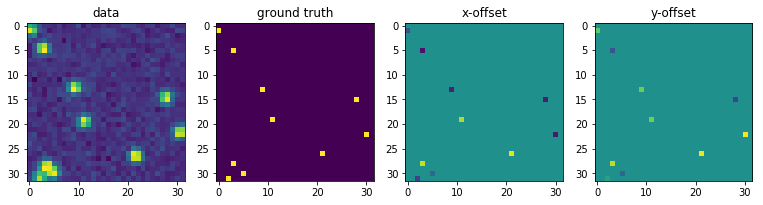

In [4]:
fig = plt.figure()
fig.set_size_inches(13, 4)
plt.subplot(1, 4, 1)
plt.imshow(x[0,:,:])
plt.title("data")
plt.subplot(1, 4, 2)
plt.imshow(y[0,:,:])
plt.title("ground truth")
plt.subplot(1, 4, 3)
plt.imshow(y[1,:,:], vmin=-0.5, vmax=0.5)
# plt.colorbar()
plt.title("x-offset")
plt.subplot(1, 4, 4)
plt.imshow(y[2,:,:], vmin=-0.5, vmax=0.5)
plt.title("y-offset")
# plt.colorbar()


### Setup a Dataloader

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)

## Loss function

## Network

In [6]:
def GammaNetLoss(scores, target, entropy=True):
    if entropy:
        loss = nn.BCEWithLogitsLoss()(scores.float(), target.float())
    else:
        scores = nn.Sigmoid()(scores)
        loss = nn.MSELoss()(scores.float(), target.float())
    return loss

In [7]:
test_loss = GammaNetLoss(torch.rand(4,1,16,16), torch.rand(4,1,16,16))

### Define network

In [8]:
class conv1x1(nn.Module):
    def __init__(self, n_in, n_out, activate=False, stride=1, bias=True):
        super(conv1x1, self).__init__()
        self.conv1 = nn.Conv2d(n_in, n_out, kernel_size=1, stride=stride, padding=0, bias=bias)
        torch.nn.init.kaiming_normal_( self.conv1.weight )
        self.bn1 = torch.nn.BatchNorm2d(n_out)
        nn.init.constant_(self.bn1.weight, 1)
        nn.init.constant_(self.bn1.bias, 0)
        self.activate = activate

    def forward(self,x):
        x = self.bn1(self.conv1(x))
        if self.activate:
            x = F.relu(x)
        return x    

class conv3x3(nn.Module):
    def __init__(self, n_in, n_out, activate=True, stride=1, bias=True):
        super(conv3x3, self).__init__()
        self.conv1 = nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1, bias=bias)
        torch.nn.init.kaiming_normal_( self.conv1.weight )
        self.bn1 = torch.nn.BatchNorm2d(n_out)
        nn.init.constant_(self.bn1.weight, 1)
        nn.init.constant_(self.bn1.bias, 0)
        self.activate = activate

    def forward(self,x):
        x = self.bn1(self.conv1(x))
        if self.activate:
            x = F.relu(x)
        return x


class GammaNet(nn.Module):
    def __init__(self, n_filters, n_hidden, n_in, n_out):
        super(GammaNet, self).__init__()
        self.input = conv3x3(n_in, n_filters)
        self.output = conv1x1(n_filters, n_out)
        layer = conv3x3(n_filters, n_filters)
        self.hidden = nn.Sequential(
            *[layer for i in range(n_hidden-1)]
        )
        
    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

### Print net arch

In [10]:
model = GammaNet(n_filters=32, n_hidden=5, n_in=1, n_out=1)
print(model)

GammaNet(
  (input): conv3x3(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): conv1x1(
    (conv1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden): Sequential(
    (0): conv3x3(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): conv3x3(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): conv3x3(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  

## Train the network

### Parameters

In [14]:
use_cuda = True
gpu_id = "cuda:1"
n_epochs = 500
lr = 0.001
l2_lambda = 1e-4

### Optimizer

In [15]:
optimizer = optim.Adam

## Validation dataset

In [16]:
val_dataset = PhotonImages("val.h5")
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=1)

### Run

In [17]:
if use_cuda:
    model.to(gpu_id)
    
seen = 0
train_loss_list = []
val_loss_list = []
    
for epoch in range(n_epochs):
    if epoch % 200 == 0 and epoch > 0:
        lr /= 10.0
    for i, (x,y) in enumerate(train_dataloader):
        my_optimizer = optimizer(model.parameters(), lr=lr, weight_decay=l2_lambda)
        if use_cuda:
            x = x.to(gpu_id)
            y = y.to(gpu_id)
        model.train()
        my_optimizer.zero_grad()
        scores = model(x)
        loss = GammaNetLoss(scores, y[:,[0],:,:], entropy=True)
        loss.backward()
        my_optimizer.step()
        seen += x.size(0)
#         print("epoch", epoch, "iteration", i, "seen", seen, "loss", float(loss.data))
        train_loss_list.append((seen, float(loss.data)))
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_seen = 0
        for j, (x,y) in enumerate(val_dataloader):
            if use_cuda:
                x = x.to(gpu_id)
                y = y.to(gpu_id)
            scores = model(x)
            loss = GammaNetLoss(scores, y[:,[0],:,:], entropy=True)
            val_seen += x.size(0)
            val_loss += x.size(0) * float(loss.data)
        val_loss /= val_seen
        val_loss_list.append((seen, val_loss))
        print("epoch", epoch, "seen", seen, "val. loss", float(val_loss))
            

epoch 0 seen 10240 val. loss 0.6382383108139038
epoch 1 seen 20480 val. loss 0.6747307777404785
epoch 2 seen 30720 val. loss 0.6766245365142822
epoch 3 seen 40960 val. loss 0.6745631694793701
epoch 4 seen 51200 val. loss 0.665546178817749
epoch 5 seen 61440 val. loss 0.649969220161438
epoch 6 seen 71680 val. loss 0.6367738842964172
epoch 7 seen 81920 val. loss 0.6339958906173706
epoch 8 seen 92160 val. loss 0.6371674537658691
epoch 9 seen 102400 val. loss 0.6292175054550171
epoch 10 seen 112640 val. loss 0.6212548613548279
epoch 11 seen 122880 val. loss 0.6143060922622681
epoch 12 seen 133120 val. loss 0.6091228723526001
epoch 13 seen 143360 val. loss 0.6028875112533569
epoch 14 seen 153600 val. loss 0.596738338470459
epoch 15 seen 163840 val. loss 0.5876564979553223
epoch 16 seen 174080 val. loss 0.5840704441070557
epoch 17 seen 184320 val. loss 0.5807176828384399
epoch 18 seen 194560 val. loss 0.5786942839622498
epoch 19 seen 204800 val. loss 0.5718497037887573
epoch 20 seen 215040 v

epoch 161 seen 1658880 val. loss 0.15690085291862488
epoch 162 seen 1669120 val. loss 0.1545935720205307
epoch 163 seen 1679360 val. loss 0.15232783555984497
epoch 164 seen 1689600 val. loss 0.15071237087249756
epoch 165 seen 1699840 val. loss 0.15007710456848145
epoch 166 seen 1710080 val. loss 0.14896930754184723
epoch 167 seen 1720320 val. loss 0.14608050882816315
epoch 168 seen 1730560 val. loss 0.14620187878608704
epoch 169 seen 1740800 val. loss 0.14317947626113892
epoch 170 seen 1751040 val. loss 0.14171013236045837
epoch 171 seen 1761280 val. loss 0.1395968198776245
epoch 172 seen 1771520 val. loss 0.1401205062866211
epoch 173 seen 1781760 val. loss 0.13823570311069489
epoch 174 seen 1792000 val. loss 0.13710355758666992
epoch 175 seen 1802240 val. loss 0.13585764169692993
epoch 176 seen 1812480 val. loss 0.1368587464094162
epoch 177 seen 1822720 val. loss 0.13347622752189636
epoch 178 seen 1832960 val. loss 0.13185501098632812
epoch 179 seen 1843200 val. loss 0.129890710115432

epoch 316 seen 3246080 val. loss 0.09592454880475998
epoch 317 seen 3256320 val. loss 0.09591100364923477
epoch 318 seen 3266560 val. loss 0.09594279527664185
epoch 319 seen 3276800 val. loss 0.09563460946083069
epoch 320 seen 3287040 val. loss 0.09605559706687927
epoch 321 seen 3297280 val. loss 0.09571394324302673
epoch 322 seen 3307520 val. loss 0.09565740823745728
epoch 323 seen 3317760 val. loss 0.09604018926620483
epoch 324 seen 3328000 val. loss 0.09542270004749298
epoch 325 seen 3338240 val. loss 0.09539622068405151
epoch 326 seen 3348480 val. loss 0.09539388120174408
epoch 327 seen 3358720 val. loss 0.0950927734375
epoch 328 seen 3368960 val. loss 0.09560080617666245
epoch 329 seen 3379200 val. loss 0.09498865157365799
epoch 330 seen 3389440 val. loss 0.09513332694768906
epoch 331 seen 3399680 val. loss 0.09524184465408325
epoch 332 seen 3409920 val. loss 0.09492304921150208
epoch 333 seen 3420160 val. loss 0.09473519027233124
epoch 334 seen 3430400 val. loss 0.094621412456035

epoch 472 seen 4843520 val. loss 0.08968563377857208
epoch 473 seen 4853760 val. loss 0.08970720320940018
epoch 474 seen 4864000 val. loss 0.08973778039216995
epoch 475 seen 4874240 val. loss 0.08969323337078094
epoch 476 seen 4884480 val. loss 0.08974634110927582
epoch 477 seen 4894720 val. loss 0.08966325223445892
epoch 478 seen 4904960 val. loss 0.08966748416423798
epoch 479 seen 4915200 val. loss 0.08967132121324539
epoch 480 seen 4925440 val. loss 0.08960380405187607
epoch 481 seen 4935680 val. loss 0.08963127434253693
epoch 482 seen 4945920 val. loss 0.08963756263256073
epoch 483 seen 4956160 val. loss 0.08965396881103516
epoch 484 seen 4966400 val. loss 0.08966314792633057
epoch 485 seen 4976640 val. loss 0.08961422741413116
epoch 486 seen 4986880 val. loss 0.0896269679069519
epoch 487 seen 4997120 val. loss 0.08962348103523254
epoch 488 seen 5007360 val. loss 0.08964642137289047
epoch 489 seen 5017600 val. loss 0.08956457674503326
epoch 490 seen 5027840 val. loss 0.089532107114

In [18]:
np.array(train_loss_list).shape

(5000, 2)

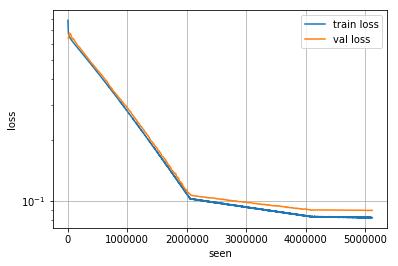

In [20]:
fig = plt.figure()
plt.semilogy(np.array(train_loss_list)[:,0], np.array(train_loss_list)[:,1], label="train loss")
plt.semilogy(np.array(val_loss_list)[:,0], np.array(val_loss_list)[:,1], label="val loss")
plt.xlabel("seen")
plt.ylabel("loss")
plt.legend()
plt.grid()

### Visualize on-the-fly data

In [21]:
with torch.no_grad():
    x_np = x.cpu().numpy()
    y_np = y.cpu().numpy()
    scores_np = nn.Sigmoid()(scores).cpu().detach().numpy()

Text(0.5, 1.0, 'prediction')

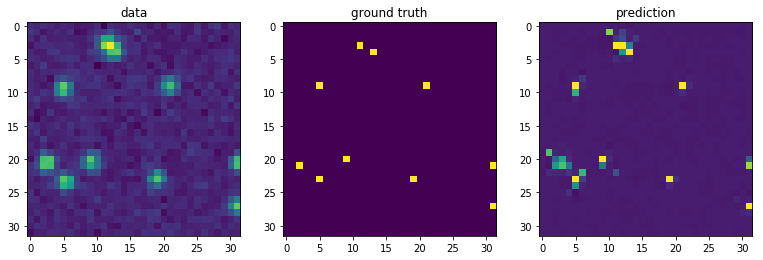

In [22]:
fig = plt.figure()
fig.set_size_inches(13, 4)
plt.subplot(1, 3, 1)
plt.imshow(x_np[0,0,:,:])
plt.title("data")
plt.subplot(1, 3, 2)
plt.imshow(y_np[0,0,:,:], vmin=0, vmax=1)
plt.title("ground truth")
plt.subplot(1, 3, 3)
plt.imshow(scores_np[0,0,:,:], vmin=0, vmax=1)
plt.title("prediction")